In [1]:
import pandas as pd
from glob import glob

In [3]:
def load_data():
    # Read all CSV files from ../Data directory
    data_names = glob('../Data/*.csv')
    data_files = pd.concat([pd.read_csv(f) for f in data_names])

    # Process data similar to R code
    data_aggr = (data_files[data_files['Trial_type'] == 'experiment']
                 .query('Rt > 0.0')
                 [['PART_ID', 'CSI', 'Corr']]
                 .assign(t=lambda x: x['CSI'] * 16.6)
                 .groupby(['PART_ID', 't'])
                 .agg({'Corr': lambda x: 100.0 * x.mean()})
                 .rename(columns={'Corr': 'mean_corr'})
                 .reset_index())
    return data_aggr


# Example usage:
data_aggr = load_data()
random_part_id = data_aggr['PART_ID'].iloc[0]  #
random_part_id

'100M32'

In [14]:
df = data_aggr[data_aggr["PART_ID"] == "145K21"]

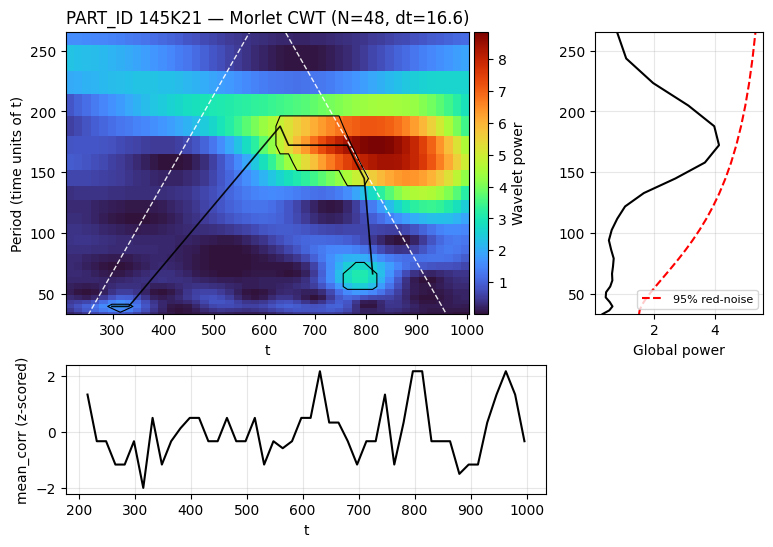

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# pip install pycwt
import pycwt as wavelet

def analyze_wavelet(df,
                    part_ids=None,
                    voices_per_octave=8,
                    period_samples_min=2,
                    period_samples_max=16,
                    detrend='constant',
                    sig_level=0.95,
                    w0=6,
                    resample_tol=0.05,
                    show=True):
    """
    Continuous wavelet analysis per participant with Torrence–Compo significance.
    - df: columns PART_ID, t (x-axis; time), mean_corr (y-axis)
    - For N≈48 samples, trustworthy periods are ~2–16 samples (outside COI).
    """

    def _estimate_ar1(y):
        y = np.asarray(y, float)
        y = y - np.mean(y)
        if len(y) < 3:
            return 0.0
        y1, y2 = y[:-1], y[1:]
        denom = np.dot(y1, y1)
        if denom == 0 or not np.isfinite(denom):
            return 0.0
        r = np.dot(y1, y2) / denom
        if not np.isfinite(r):
            r = 0.0
        return float(np.clip(r, -0.99, 0.99))

    def _preprocess_tseries(sub):
        sub = sub.sort_values('t').dropna(subset=['t', 'mean_corr']).copy()
        t = sub['t'].astype(float).to_numpy()
        y = sub['mean_corr'].astype(float).to_numpy()

        # Detrend: mean-only by default to avoid overfitting on short series
        if detrend == 'linear':
            X = np.vstack([np.ones_like(t), t - t.mean()]).T
            beta = np.linalg.lstsq(X, y, rcond=None)[0]
            y = y - X @ beta
        else:
            y = y - np.nanmean(y)

        # Standardize (Torrence–Compo assumes sigma2 factor)
        sigma2 = np.nanvar(y, ddof=1)
        if sigma2 == 0 or not np.isfinite(sigma2):
            return None
        y = y / np.sqrt(sigma2)
        sigma2 = 1.0  # after standardization

        # Check regularity and resample to uniform grid if needed
        if len(t) < 8:
            return None
        dt_raw = np.diff(t)
        med = np.median(dt_raw)
        if np.any(~np.isfinite(dt_raw)) or med <= 0:
            return None
        if np.max(np.abs(dt_raw - med) / med) > resample_tol:
            # interpolate to uniform grid of same length
            t_u = np.linspace(t.min(), t.max(), len(t))
            y_u = np.interp(t_u, t, y)
            t, y = t_u, y_u
        dt = float((t[-1] - t[0]) / (len(t) - 1))
        return t, y, dt, sigma2

    def _period_band(N, dt):
        # Period bounds in time units from "samples" bounds
        pmin = period_samples_min * dt
        pmax = min(period_samples_max, N / 3.0) * dt  # conservative COI-aware
        return pmin, pmax

    if part_ids is None:
        part_ids = df['PART_ID'].dropna().unique().tolist()

    mother = wavelet.Morlet(w0)
    flambda = mother.flambda()  # Fourier period per scale at dt=1

    results = {}

    for pid in part_ids:
        sub = df[df['PART_ID'] == pid]
        if sub.empty:
            continue
        prep = _preprocess_tseries(sub)
        if prep is None:
            continue
        t, y, dt, sigma2 = prep
        N = len(y)

        # Choose scales from desired period band
        pmin, pmax = _period_band(N, dt)
        if not (np.isfinite(pmin) and np.isfinite(pmax) and pmax > pmin):
            continue
        s0 = pmin / flambda
        dj = 1.0 / voices_per_octave
        J = int(np.floor(np.log2(pmax / pmin) / dj))
        if J < 4:
            continue

        # Continuous wavelet transform
        wave, scales, freqs, coi, fft, fftfreqs = wavelet.cwt(y, dt, dj, s0, J, mother)
        power = np.abs(wave) ** 2
        period = flambda * scales  # same units as t

        # Red-noise AR(1) significance (Torrence–Compo)
        lag1 = _estimate_ar1(y)  # scalar
        signif, fft_theor = wavelet.significance(
            1.0, dt, scales, 0, lag1, significance_level=sig_level, wavelet=mother
        )
        signif_2d = signif[:, None]  # broadcast across time since sigma2=1

        # Cone of influence mask: only trust where period <= coi(t)
        outside_coi = period[:, None] <= coi[None, :]

        # Significant regions
        sig_mask = (power >= signif_2d) & outside_coi

        # Ridge: for each time, pick period at max power among significant scales
        ridge_period = np.full(N, np.nan)
        for i in range(N):
            idx = np.where(sig_mask[:, i])[0]
            if idx.size:
                k = idx[np.argmax(power[idx, i])]
                ridge_period[i] = period[k]

        # Global wavelet spectrum (time-average of power)
        gws = power.mean(axis=1)

        results[pid] = dict(t=t, y=y, dt=dt, period=period, power=power,
                            coi=coi, signif=signif, sig_mask=sig_mask,
                            ridge_period=ridge_period, gws=gws, lag1=lag1,
                            pmin=pmin, pmax=pmax)

        if show:
            fig = plt.figure(figsize=(9, 6))
            gs = fig.add_gridspec(2, 2, height_ratios=[2.2, 1.0], width_ratios=[4.0, 1.4], hspace=0.25, wspace=0.15)
            ax = fig.add_subplot(gs[0, 0])
            axg = fig.add_subplot(gs[0, 1], sharey=ax)
            axy = fig.add_subplot(gs[1, 0])
            ax.set_title(f'PART_ID {pid} — Morlet CWT (N={N}, dt={dt:.3g})')

            # Scalogram (power)
            T, P = np.meshgrid(t, period)
            im = ax.pcolormesh(T, P, power, shading='auto', cmap='turbo')
            ax.plot(t, coi, 'w--', lw=1, alpha=0.9, label='COI')
            # Significance contour
            ax.contour(T, P, sig_mask, levels=[0.5], colors='k', linewidths=0.8)
            # Ridge
            ax.plot(t[np.isfinite(ridge_period)], ridge_period[np.isfinite(ridge_period)],
                    'k-', lw=1.2, alpha=0.9, label='Ridge (significant)')
            ax.set_ylabel('Period (time units of t)')
            ax.set_xlabel('t')
            ax.set_ylim(pmin, pmax)
            ax.invert_yaxis()
            cbar = fig.colorbar(im, ax=ax, orientation='vertical', pad=0.01)
            cbar.set_label('Wavelet power')

            # Global wavelet spectrum
            axg.plot(gws, period, 'k-')
            axg.plot(signif, period, 'r--', label=f'{int(sig_level*100)}% red-noise')
            axg.set_xlabel('Global power')
            axg.set_ylim(ax.get_ylim())
            axg.invert_yaxis()
            axg.grid(True, alpha=0.3)
            axg.legend(loc='lower right', fontsize=8)

            # Original series (standardized)
            axy.plot(t, y, 'k-')
            axy.set_xlabel('t')
            axy.set_ylabel('mean_corr (z-scored)')
            axy.grid(True, alpha=0.3)

            plt.show()

    return results


# Example usage:
results = analyze_wavelet(df, part_ids=[123, 456], voices_per_octave=8, period_samples_min=2, period_samples_max=16)
# For all participants:
results = analyze_wavelet(df)


In [18]:
import numpy as np
import pandas as pd
from glob import glob
import pycwt as wavelet
from scipy import stats

def load_data():
    # Read all CSV files from ../Data directory
    data_names = glob('../Data/*.csv')
    data_files = pd.concat([pd.read_csv(f) for f in data_names], ignore_index=True)

    # Process data similar to R code
    data_aggr = (data_files[data_files['Trial_type'] == 'experiment']
                 .query('Rt > 0.0')
                 [['PART_ID', 'CSI', 'Corr']]
                 .assign(t=lambda x: x['CSI'] * 16.6)
                 .groupby(['PART_ID', 't'], as_index=False)
                 .agg(mean_corr=('Corr', lambda x: 100.0 * x.mean())))
    return data_aggr


def analyze_wavelet_group(
    df,
    voices_per_octave=8,          # dyadic density
    period_samples_min=2,          # min period in samples (k_min)
    period_samples_max=16,         # max period in samples (k_max)
    min_cycles=3,                  # require >= this many cycles for an "episode"
    detrend='constant',            # 'constant' or 'linear'
    sig_level=0.95,                # pixelwise Torrence–Compo level
    w0=6,                          # Morlet omega0
    resample_tol=0.05,             # allow <=5% jitter; else resample to uniform grid
    B=100,                         # AR(1) surrogates per subject for null p
    S=4000,                        # Monte Carlo samples for Poisson–binomial p-values
    seed=0,                        # RNG seed
    return_subject_details=False   # return per-subject episode matrix
):
    """
    Group-level prevalence test: do many participants show significant oscillatory episodes
    at each target period (in samples), anywhere in time.

    Input df must have columns: PART_ID, t, mean_corr.
    """

    rng = np.random.default_rng(seed)
    mother = wavelet.Morlet(w0)
    flambda = mother.flambda()  # Fourier period per scale at dt=1

    # Target periods in samples (k). Use integers for clear "cycles" counting.
    k_vals = np.arange(int(np.ceil(period_samples_min)), int(np.floor(period_samples_max)) + 1)
    if k_vals.size < 1:
        raise ValueError("No target periods; check period_samples_min/max.")

    # Helpers
    def _estimate_ar1(y):
        y = np.asarray(y, float)
        y = y - np.mean(y)
        if y.size < 3:
            return 0.0
        y1, y2 = y[:-1], y[1:]
        denom = np.dot(y1, y1)
        if denom <= 0 or not np.isfinite(denom):
            return 0.0
        r = float(np.dot(y1, y2) / denom)
        return float(np.clip(r, -0.99, 0.99))

    def _preprocess_tseries(sub):
        sub = sub.sort_values('t').dropna(subset=['t', 'mean_corr']).copy()
        t = sub['t'].astype(float).to_numpy()
        y = sub['mean_corr'].astype(float).to_numpy()

        if y.size < 8:
            return None

        # Detrend
        if detrend == 'linear':
            X = np.vstack([np.ones_like(t), t - t.mean()]).T
            beta = np.linalg.lstsq(X, y, rcond=None)[0]
            y = y - X @ beta
        else:
            y = y - np.nanmean(y)

        # Standardize to unit variance
        s2 = np.nanvar(y, ddof=1)
        if not np.isfinite(s2) or s2 == 0:
            return None
        y = y / np.sqrt(s2)

        # Regularize sampling
        dt_raw = np.diff(t)
        if not np.all(np.isfinite(dt_raw)):
            return None
        med = np.median(dt_raw)
        if med <= 0:
            return None
        if np.max(np.abs(dt_raw - med) / med) > resample_tol:
            t_u = np.linspace(t.min(), t.max(), len(t))
            y_u = np.interp(t_u, t, y)
            t, y = t_u, y_u
        dt = float((t[-1] - t[0]) / (len(t) - 1))
        if not np.isfinite(dt) or dt <= 0:
            return None
        return t, y, dt

    def _longest_true_run(mask_bool):
        # length (in samples) of the longest contiguous True run
        maxlen = 0
        cur = 0
        for b in mask_bool:
            if b:
                cur += 1
                if cur > maxlen:
                    maxlen = cur
            else:
                cur = 0
        return maxlen

    part_ids = df['PART_ID'].dropna().unique().tolist()
    n_subj_total = len(part_ids)

    # Storage
    obs_episodes = []     # per subject boolean [len(k_vals)]
    null_probs = []       # per subject per k
    kept_ids = []         # subjects that passed preprocessing
    subj_dt = []          # for reporting

    for pid in part_ids:
        sub = df[df['PART_ID'] == pid]
        prep = _preprocess_tseries(sub)
        if prep is None:
            continue
        t, y, dt = prep
        N = len(y)

        # Period band in time units based on k bounds
        pmin, pmax = k_vals[0] * dt, k_vals[-1] * dt
        if not (np.isfinite(pmin) and np.isfinite(pmax) and pmax > pmin):
            continue

        # Choose scales to densely cover [pmin, pmax]
        dj = 1.0 / voices_per_octave
        s0 = pmin / flambda
        J = int(np.floor(np.log2(pmax / pmin) / dj))
        if J < 4:
            continue

        # Subject CWT and significance
        wave, scales, freqs, coi, fft, fftfreqs = wavelet.cwt(y, dt, dj, s0, J, mother)
        power = np.abs(wave) ** 2
        period = flambda * scales  # time units

        lag1 = _estimate_ar1(y)
        signif_vec, _ = wavelet.significance(1.0, dt, scales, 0, lag1,
                                             significance_level=sig_level, wavelet=mother)
        signif_2d = signif_vec[:, None]
        outside_coi = period[:, None] <= coi[None, :]
        sig_mask = (power >= signif_2d) & outside_coi  # [n_scales, N]

        # Map each target k to nearest scale row and detect episodes
        episodes = np.zeros_like(k_vals, dtype=bool)
        for i_k, k in enumerate(k_vals):
            T_k = k * dt
            si = int(np.argmin(np.abs(period - T_k)))
            # Run-length threshold in samples
            required_len = int(np.ceil(min_cycles * k))
            mask_t = sig_mask[si, :]
            if _longest_true_run(mask_t) >= required_len:
                episodes[i_k] = True

        # Estimate null probabilities via AR(1) surrogates
        hits = np.zeros_like(k_vals, dtype=int)
        # Elements fixed across surrogates:
        sigma_e = np.sqrt(max(1.0 - lag1**2, 1e-8))
        for b in range(B):
            # AR(1) surrogate with unit variance
            y_surr = np.empty(N, dtype=float)
            y_surr[0] = rng.normal(0, 1.0)
            e = rng.normal(0, sigma_e, size=N)
            for n in range(1, N):
                y_surr[n] = lag1 * y_surr[n-1] + e[n]

            wave_s, _, _, coi_s, _, _ = wavelet.cwt(y_surr, dt, dj, s0, J, mother)
            power_s = np.abs(wave_s) ** 2
            # Same signif threshold (variance=1) and same scales
            outside_coi_s = period[:, None] <= coi_s[None, :]
            sig_mask_s = (power_s >= signif_2d) & outside_coi_s

            for i_k, k in enumerate(k_vals):
                si = int(np.argmin(np.abs(period - (k * dt))))
                required_len = int(np.ceil(min_cycles * k))
                if _longest_true_run(sig_mask_s[si, :]) >= required_len:
                    hits[i_k] += 1

        p0 = hits / max(B, 1)

        kept_ids.append(pid)
        subj_dt.append(dt)
        obs_episodes.append(episodes)
        null_probs.append(p0)

    if len(kept_ids) == 0:
        raise RuntimeError("No subjects passed preprocessing; check your data and parameters.")

    obs_episodes = np.vstack(obs_episodes)      # [n_kept, K]
    null_probs = np.vstack(null_probs)          # [n_kept, K]
    n_kept = obs_episodes.shape[0]

    obs_counts = obs_episodes.sum(axis=0)       # per period k
    prevalence = obs_counts / n_kept

    # Poisson–binomial Monte Carlo p-values using subject-specific null probabilities
    rng = np.random.default_rng(seed + 1)
    pvals = np.ones_like(k_vals, dtype=float)
    for j in range(len(k_vals)):
        pk = null_probs[:, j]
        sums = (rng.random((S, n_kept)) < pk[None, :]).sum(axis=1)
        # right-tail p-value: P(null sum >= observed)
        pvals[j] = (np.sum(sums >= obs_counts[j]) + 1) / (S + 1)

    # Benjamini–Hochberg FDR across periods
    order = np.argsort(pvals)
    m = len(pvals)
    alpha = 0.05
    crit = (np.arange(1, m + 1) * alpha) / m
    passed = np.zeros(m, dtype=bool)
    passed[order] = pvals[order] <= np.maximum.accumulate(crit)

    # Summary table
    median_dt = float(np.median(subj_dt))
    summary = pd.DataFrame({
        'period_k': k_vals,
        'approx_period_time': k_vals * median_dt,  # in same units as t
        'n_subjects': n_kept,
        'count_with_episode': obs_counts,
        'prevalence': prevalence,
        'p_value': pvals,
        'passed_fdr_0p05': passed
    })

    outputs = {
        'summary': summary,
        'kept_participants': kept_ids,
        'median_dt': median_dt,
        'k_vals': k_vals,
        'obs_episodes_matrix': obs_episodes if return_subject_details else None,
        'null_probs_matrix': null_probs if return_subject_details else None
    }
    return outputs


# Example usage:
data_aggr = load_data()
results = analyze_wavelet_group(
    data_aggr,
    voices_per_octave=8,
    period_samples_min=2,
    period_samples_max=16,
    min_cycles=3,
    B=100,      # increase for more accurate null estimates; runtime grows ~ linearly
    S=4000,     # increase for tighter p-values
    seed=0,
    return_subject_details=True
)
print(results['summary'])

    period_k  approx_period_time  n_subjects  count_with_episode  prevalence  \
0          2                33.2         146                   0    0.000000   
1          3                49.8         146                   3    0.020548   
2          4                66.4         146                   1    0.006849   
3          5                83.0         146                   1    0.006849   
4          6                99.6         146                   1    0.006849   
5          7               116.2         146                   0    0.000000   
6          8               132.8         146                   0    0.000000   
7          9               149.4         146                   0    0.000000   
8         10               166.0         146                   0    0.000000   
9         11               182.6         146                   0    0.000000   
10        12               199.2         146                   0    0.000000   
11        13               215.8        

In [19]:
results['summary']

,period_k,approx_period_time,n_subjects,count_with_episode,prevalence,p_value,passed_fdr_0p05
0,2,33.2,146,0,0.000000,1.000000,False
1,3,49.8,146,3,0.020548,0.657836,False
2,4,66.4,146,1,0.006849,0.865784,False
3,5,83.0,146,1,0.006849,0.756311,False
4,6,99.6,146,1,0.006849,0.595101,False
5,7,116.2,146,0,0.000000,1.000000,False
6,8,132.8,146,0,0.000000,1.000000,False
7,9,149.4,146,0,0.000000,1.000000,False
8,10,166.0,146,0,0.000000,1.000000,False
9,11,182.6,146,0,0.000000,1.000000,False
